## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_gadget
from cup1d.data import data_nyx
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim))
else:
    drop_sim=None

In [3]:
# add high-k measurement (will change emulator settings as well)
add_hires=False
if add_hires:
    kmax_Mpc=8
    polyfit_ndeg=7
else:
    kmax_Mpc=4
    polyfit_ndeg=5
    extra_data=None

In [4]:
# specify simulation suite and P1D mesurements
z_max=4.5
data_label='Chabanier2019'
use_nyx=False
if use_nyx:
    emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "lambda_P"]
    archive=nyx_archive.NyxArchive(verbose=True)
    data=data_nyx.Nyx_P1D(archive=archive,sim_label="nyx_"+str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg)
    # option to add extra P1D (high-resolution)
    if add_hires:
        extra_data=data_nyx.Nyx_P1D(archive=archive,
                                sim_label="nyx_"+str(test_sim_label),
                                z_max=z_max,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg,
                                data_cov_label='Karacayli2022')
else:
    archive=gadget_archive.GadgetArchive(postproc='Cabayol23')
    data=data_gadget.Gadget_P1D(archive=archive,sim_label="mpg_"+str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg)
    # option to add extra P1D (high-resolution)
    if add_hires:
        extra_data=data_gadget.Gadget_P1D(archive=archive,
                                sim_label="mpg_"+str(test_sim_label),
                                z_max=z_max,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg,
                                data_cov_label='Karacayli2022')

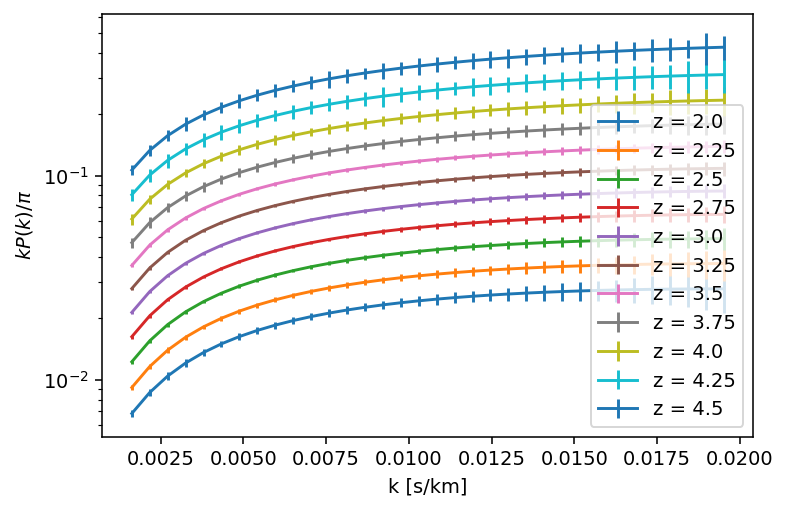

In [5]:
data.plot_p1d()

In [6]:
if extra_data:
    extra_data.plot_p1d()

### Emulator and training set

Create a set of training data to train an emulator

In [7]:
if use_nyx:
    emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "lambda_P"]
else:
    emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"]

In [8]:
use_gp=True
if use_gp:
    if use_nyx:
        raise ValueError('can not use GP with Nyx emulator')
    emulator=gp_emulator.GPEmulator(archive=archive,emu_params=emu_params,
                                    drop_sim=drop_sim,kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)
else:
    emulator=nn_emulator.NNEmulator(archive=archive,emu_params=emu_params,
                                    drop_sim=drop_sim,kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)

Use custom archive provided by the user
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.31 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [9]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [10]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emulator,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

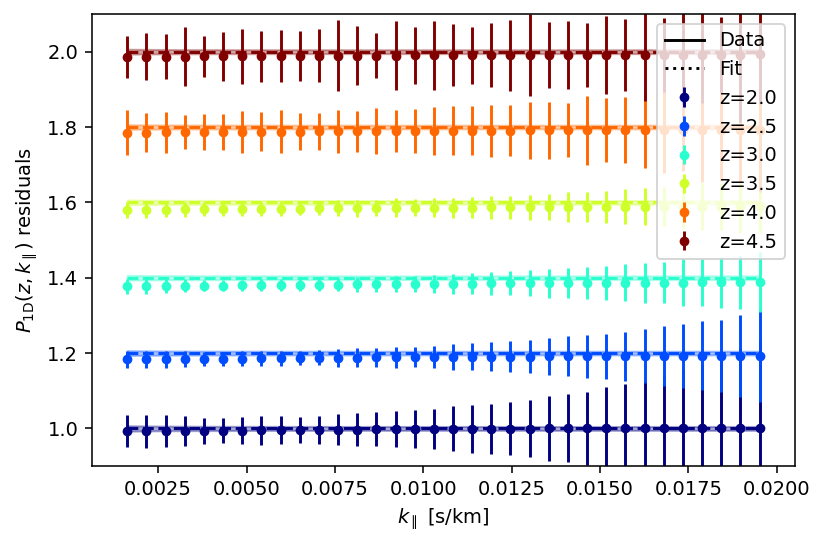

In [11]:
like.plot_p1d(residuals=True,plot_every_iz=2)

In [12]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=2)

# Try iminuit minimizer

In [13]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 43.72685567298745


In [14]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [15]:
minimizer.minimize(compute_hesse=True)

In [16]:
best_fit_values=np.array(minimizer.minimizer.values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

chi2 improved from 43.72685567298745 to 0.03138514307722437


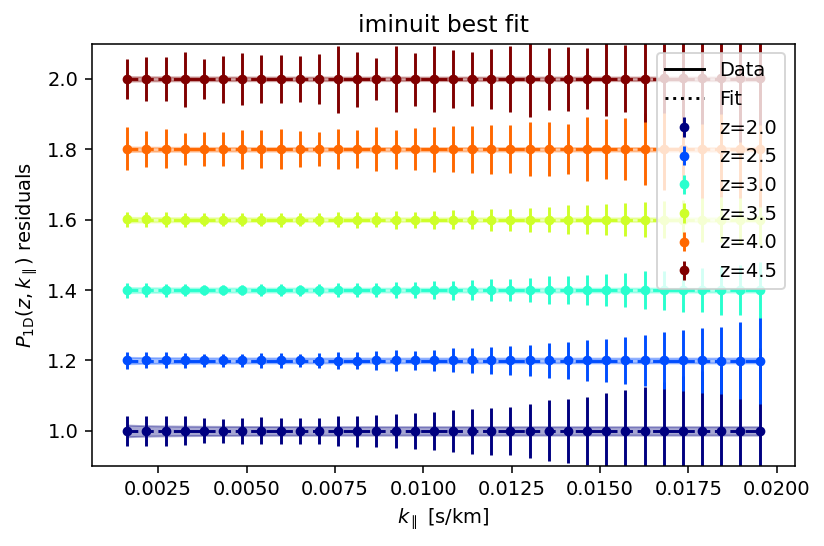

In [17]:
minimizer.plot_best_fit(plot_every_iz=2)

In [18]:
if extra_data:
    like.extra_p1d_like.plot_p1d(values=best_fit_values,residuals=True,plot_every_iz=2)

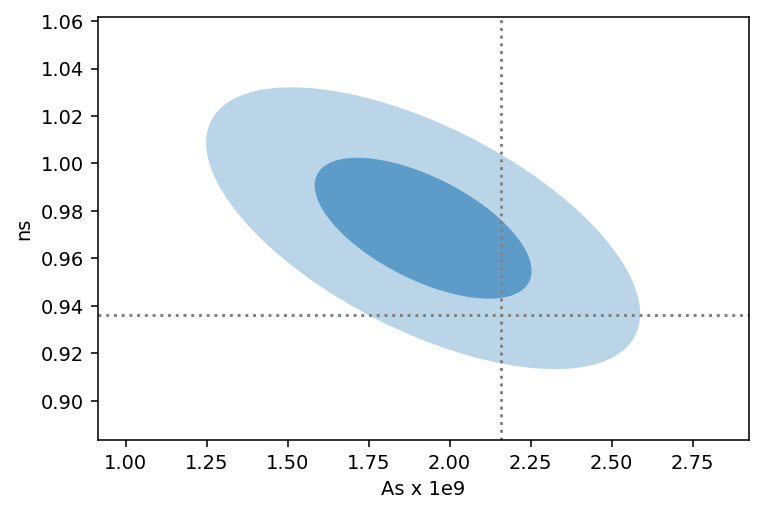

In [19]:
minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [20]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 118.5                      │              Nfcn = 929              │
│ EDM = 1.16e-06 (Goal: 0.0001)    │           time = 23.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.42    │   0.15    │            │            │         │         │       │
│ 1 │ x1   │   0.55    │   0.17    │            │            │         │         │       │
│ 2 │ x2   │    0.5    │    0.5    │            │            │         │         │       │
│ 3 │ x3   │   0.51    │   0.33    │            │            │         │         │       │
│ 4 │ x4   │    0.5    │    0.7    │            │            │         │         │       │
│ 5 │ x5   │    0.3    │    0.6    │            │            │         │         │       │
│ 6 │ x6   │    0.4    │    0.7    │            │            │         │         │       │
│ 7 │ x7   │    0.6    │    1.2    │            │            │         │         │       │
│ 8 │ x8   │    0.4    │    1.1    │            │            │         │         │       │
│ 9 │ x9   │    0.7    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5       x6       x7       x8       x9 │
├────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.0213  -0.0141 -0.00079  -0.0311   0.0234   0.0633   0.0165   0.0764   0.0396  -0.0518 │
│ x1 │  -0.0141   0.0283  -0.0292   0.0312  -0.0497  -0.0874  -0.0313  -0.0256  -0.0659   0.0824 │
│ x2 │ -0.00079  -0.0292    0.204   -0.106      0.3     0.12    0.119    -0.12    0.246   -0.273 │
│ x3 │  -0.0311   0.0312   -0.106    0.105   -0.191   -0.145  -0.0795  -0.0614    -0.17     0.21 │
│ x4 │   0.0234  -0.0497      0.3   -0.191    0.484    0.237     0.19  -0.0753    0.421   -0.473 │
│ x5 │   0.0633  -0.0874     0.12   -0.145    0.237    0.333    0.103     0.18    0.255   -0.374 │
│ x6 │   0.0165  -0.0313    0.119  -0.0795     0.19    0.103    0.553    -0.68    0.806   -0.222 │
│ x7 │   0.0764  -0.0256    -0.12  -0.0614  -0.0753     0.18    -0.68     1.34   -0.875 -0.00421 │
│ x8 │   0.0396  -0.0659    0.246    -0.17    0.421    0.255    0.806   -0.875     1.27   -0.492 │
│ x9 │  -0.0518   0.0824   -0.273     0.21   -0.473   -0.374   -0.222 -0.00421   -0.492    0.696 │
└────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [21]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [22]:
#minimizer.minimizer.draw_mnprofile("x0")